# MNIST Handwritten Digit Recognizer

In this notebook, I implemented a simple two-layer neural network and trained it on the MNIST digit recognizer dataset.

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

data = pd.read_csv('train.csv')

In [4]:
data.shape

(42000, 785)

42k images(rows) and 1 column for label + 784 pixels(columns) in train set

In [5]:
data = np.array(data)
m, n = data.shape  # m = rows, n = columns
np.random.shuffle(data) # shuffle before splitting into dev and training sets

data_dev = data[0:1000].T
Y_dev = data_dev[0]   #Y_dev has labels as vertical matrix
X_dev = data_dev[1:n] #X_dev has in each column, all the pixels of that image
X_dev = X_dev / 255.  #doubt

data_train = data[1000:m].T
Y_train = data_train[0]
X_train = data_train[1:n]
X_train = X_train / 255.
_,m_train = X_train.shape

In [6]:
X_train.shape

(784, 41000)

Our NN will have a simple two-layer architecture. Input layer $a^{[0]}$ will have 784 units corresponding to the 784 pixels in each 28x28 input image. A hidden layer $a^{[1]}$ will have 10 units with ReLU activation, and finally our output layer $a^{[2]}$ will have 10 units corresponding to the ten digit classes with softmax activation.

**Forward propagation**

$$Z^{[1]} = W^{[1]} X + b^{[1]}$$
$$A^{[1]} = g_{\text{ReLU}}(Z^{[1]}))$$
$$Z^{[2]} = W^{[2]} A^{[1]} + b^{[2]}$$
$$A^{[2]} = g_{\text{softmax}}(Z^{[2]})$$

**Backward propagation**

$$dZ^{[2]} = A^{[2]} - Y$$
$$dW^{[2]} = \frac{1}{m} dZ^{[2]} A^{[1]T}$$
$$dB^{[2]} = \frac{1}{m} \Sigma {dZ^{[2]}}$$
$$dZ^{[1]} = W^{[2]T} dZ^{[2]} .* g^{[1]\prime} (z^{[1]})$$
$$dW^{[1]} = \frac{1}{m} dZ^{[1]} A^{[0]T}$$
$$dB^{[1]} = \frac{1}{m} \Sigma {dZ^{[1]}}$$

**Parameter updates**

$$W^{[2]} := W^{[2]} - \alpha dW^{[2]}$$
$$b^{[2]} := b^{[2]} - \alpha db^{[2]}$$
$$W^{[1]} := W^{[1]} - \alpha dW^{[1]}$$
$$b^{[1]} := b^{[1]} - \alpha db^{[1]}$$

**Vars and shapes**

Forward prop

- $A^{[0]} = X$: 784 x m
- $Z^{[1]} \sim A^{[1]}$: 10 x m
- $W^{[1]}$: 10 x 784 (as $W^{[1]} A^{[0]} \sim Z^{[1]}$)
- $B^{[1]}$: 10 x 1
- $Z^{[2]} \sim A^{[2]}$: 10 x m
- $W^{[2]}$: 10 x 10 (as $W^{[2]} A^{[1]} \sim Z^{[2]}$)
- $B^{[2]}$: 10 x 1

Backprop

- $dZ^{[2]}$: 10 x m ($~A^{[2]}$)
- $dW^{[2]}$: 10 x 10
- $dB^{[2]}$: 10 x 1
- $dZ^{[1]}$: 10 x m ($~A^{[1]}$)
- $dW^{[1]}$: 10 x 10
- $dB^{[1]}$: 10 x 1

In [7]:
Y_train.max()

9

In [8]:
def init_params():
    W1 = np.random.rand(10, 784) - 0.5    #all 4 params to be [-0.5 to 0.5), hence -0.5 as random.rand gives (0,1]
    b1 = np.random.rand(10, 1) - 0.5      #random.rand(rows, col)
    W2 = np.random.rand(10, 10) - 0.5
    b2 = np.random.rand(10, 1) - 0.5
    return W1, b1, W2, b2

def ReLU(Z):
    return np.maximum(Z, 0)

def softmax(Z):
    A = np.exp(Z) / sum(np.exp(Z))
    return A
    
def forward_prop(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

def ReLU_deriv(Z):
    return Z > 0

def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))  #Y.max() = 9, so 10 numbers (0-9)
    one_hot_Y[np.arange(Y.size), Y] = 1   #for every row go to the coloumn where 1 should be put whichever the label is
    one_hot_Y = one_hot_Y.T  #after transpose, each column is one of 42k examples
    return one_hot_Y

def backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y):
    one_hot_Y = one_hot(Y)
    dZ2 = A2 - one_hot_Y
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2)
    dZ1 = W2.T.dot(dZ2) * ReLU_deriv(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1)
    return dW1, db1, dW2, db2

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1    
    W2 = W2 - alpha * dW2  
    b2 = b2 - alpha * db2    
    return W1, b1, W2, b2

In [9]:
def get_predictions(A2):
    return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
    print(predictions, Y)
    return np.sum(predictions == Y) / Y.size

def gradient_descent(X, Y, alpha, iterations):
    W1, b1, W2, b2 = init_params()
    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        if i % 10 == 0:
            print("Iteration: ", i)
            predictions = get_predictions(A2)
            print(get_accuracy(predictions, Y))
    return W1, b1, W2, b2

In [10]:
X_train.shape

(784, 41000)

In [11]:
W1, b1, W2, b2 = gradient_descent(X_train, Y_train, 0.10, 500)

Iteration:  0
[4 4 9 ... 4 6 4] [1 3 6 ... 9 7 0]
0.12504878048780488
Iteration:  10
[6 4 4 ... 4 6 4] [1 3 6 ... 9 7 0]
0.19048780487804878
Iteration:  20
[1 4 4 ... 4 4 0] [1 3 6 ... 9 7 0]
0.2636341463414634
Iteration:  30
[1 4 4 ... 4 3 0] [1 3 6 ... 9 7 0]
0.355390243902439
Iteration:  40
[1 3 2 ... 4 3 0] [1 3 6 ... 9 7 0]
0.4470487804878049
Iteration:  50
[1 3 6 ... 9 3 0] [1 3 6 ... 9 7 0]
0.5244634146341464
Iteration:  60
[1 3 6 ... 9 3 0] [1 3 6 ... 9 7 0]
0.5840731707317073
Iteration:  70
[1 3 6 ... 9 7 0] [1 3 6 ... 9 7 0]
0.6241707317073171
Iteration:  80
[1 3 6 ... 9 7 0] [1 3 6 ... 9 7 0]
0.6544878048780488
Iteration:  90
[1 3 6 ... 9 9 0] [1 3 6 ... 9 7 0]
0.6773658536585366
Iteration:  100
[1 3 6 ... 9 9 0] [1 3 6 ... 9 7 0]
0.6942439024390243
Iteration:  110
[1 3 6 ... 9 9 0] [1 3 6 ... 9 7 0]
0.7087073170731707
Iteration:  120
[1 3 6 ... 9 9 0] [1 3 6 ... 9 7 0]
0.7202926829268292
Iteration:  130
[1 3 6 ... 9 9 0] [1 3 6 ... 9 7 0]
0.7297317073170732
Iteration:  140


~84% accuracy on training set.

In [12]:
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

def test_prediction(index, W1, b1, W2, b2):
    current_image = X_train[:, index, None]
    prediction = make_predictions(X_train[:, index, None], W1, b1, W2, b2)
    label = Y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

Let's look at a couple of examples:

In [31]:
data2 = pd.read_csv('geek.csv')
data2 = data2.T
data2.shape
# X_train.shape
# data2.head()

(2352, 0)

In [32]:
image2 = data2[:,1,None]
pred2 = make_predicitions(image2, W1, b1, W2, b2)
image2 = image2.reshape((28,28)) * 255
plt.gray()
plt.imshow(image2, interpolation='nearest')
plt.show()

TypeError: '(slice(None, None, None), 1, None)' is an invalid key

Prediction:  [0]
Label:  0


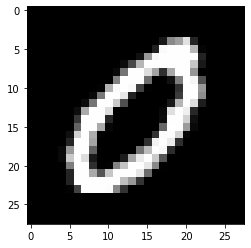

Prediction:  [3]
Label:  3


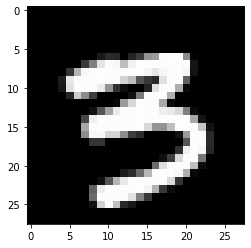

Prediction:  [5]
Label:  5


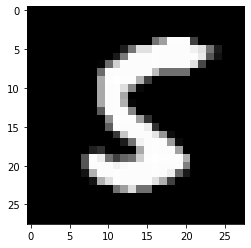

Prediction:  [5]
Label:  5


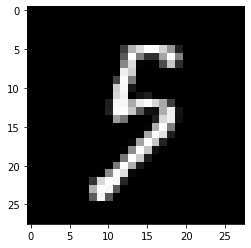

In [41]:
test_prediction(0, W1, b1, W2, b2)
test_prediction(1, W1, b1, W2, b2)
test_prediction(2, W1, b1, W2, b2)
test_prediction(3, W1, b1, W2, b2)

Finally, let's find the accuracy on the dev set:

In [28]:
dev_predictions = make_predictions(X_dev, W1, b1, W2, b2)
get_accuracy(dev_predictions, Y_dev)

[3 7 2 1 4 2 1 8 4 8 2 8 1 1 2 3 2 2 9 7 3 5 2 7 7 9 9 3 1 4 3 2 3 7 7 7 2
 6 3 2 8 0 3 7 0 1 0 6 8 6 1 1 1 6 0 3 7 9 0 0 9 6 2 6 7 1 1 2 6 7 8 1 7 0
 8 7 4 0 2 9 9 1 2 2 5 5 6 4 9 0 2 3 3 0 3 2 0 4 6 9 8 8 2 9 7 2 6 3 4 3 9
 5 5 5 7 3 7 2 8 9 6 5 8 6 0 5 6 1 1 9 7 3 6 6 9 3 4 6 2 2 3 7 2 1 2 3 9 6
 7 3 7 8 8 8 5 8 2 0 0 9 3 8 0 4 3 3 0 3 5 6 0 7 3 2 1 7 9 3 9 0 1 9 2 6 2
 1 6 1 7 1 0 1 5 0 8 9 5 2 0 5 3 7 2 7 4 0 3 0 9 9 1 6 3 4 1 6 4 6 5 1 9 2
 6 3 6 9 7 0 8 9 0 2 4 4 1 2 4 4 6 7 1 0 3 7 6 8 9 4 5 6 9 9 2 4 3 1 6 3 5
 0 7 8 1 3 0 4 0 1 0 4 9 4 9 4 9 8 1 5 0 6 1 3 6 7 1 4 5 7 8 4 6 5 3 1 8 1
 4 2 0 3 8 3 2 3 3 9 3 1 5 9 4 5 1 1 1 5 9 7 7 8 8 7 5 6 0 5 8 4 9 1 0 0 9
 3 4 1 3 9 4 4 4 4 2 9 7 7 8 8 4 5 6 2 6 6 2 6 1 7 2 3 8 5 0 3 4 0 9 5 2 3
 0 2 3 1 8 4 3 8 8 5 0 1 6 8 9 6 7 8 7 2 3 0 6 9 1 0 1 3 3 0 4 0 0 0 8 7 9
 3 8 0 2 6 5 4 4 3 4 0 6 8 8 7 4 6 9 2 1 6 9 5 3 7 3 1 2 1 0 0 6 8 1 4 0 4
 5 7 4 2 2 0 7 6 3 1 6 3 9 7 4 3 3 8 9 4 2 4 3 5 1 6 8 0 4 5 9 1 4 5 9 1 8
 0 4 9 4 6 4 1 9 6 0 4 7 

0.829

Here we get 82% accuracy, so our model generalized from the training data pretty well.